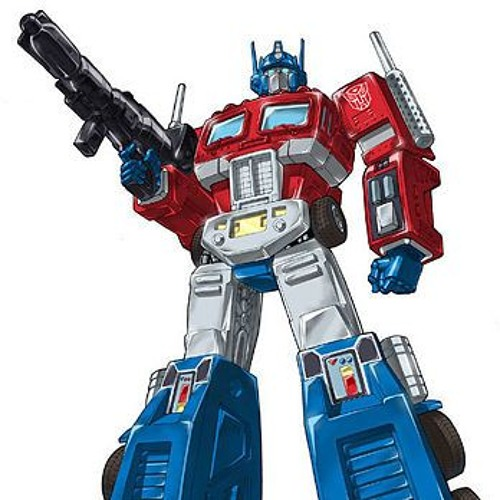

In [1]:
import os
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy
import torch.nn.functional as F

In [2]:
# downloading our dataset
if not os.path.exists('input.txt'):
    !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
else:
    print("Dataset already exists, skipping download")

Dataset already exists, skipping download


In [3]:
with open('./input.txt','r',encoding='utf-8') as f:
    text = f.read()
print("lenth of dataset is:",len(text))

lenth of dataset is: 1115394


In [4]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[n] for n in l])

In [7]:
decode([4])

'&'

In [8]:
print(encode('hii there'))

[46, 47, 47, 1, 58, 46, 43, 56, 43]


In [9]:
decode(encode('hii there'))

'hii there'

In [10]:
data = torch.tensor(encode(text),dtype=torch.long)
print(data.shape,data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [11]:
# Hyperparmeters
batch_size = 64
vocab_size = len(chars)
block_size = 16
max_iters = 3000
eval_intervals = 300
learning_rate = 1e-3
n_embd = 64

In [12]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [13]:
len(val_data)/len(train_data) * 100

11.111177521830864

In [14]:
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43])

In [15]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f'When input is: {context}, The output is {target}')

When input is: tensor([18]), The output is 47
When input is: tensor([18, 47]), The output is 56
When input is: tensor([18, 47, 56]), The output is 57
When input is: tensor([18, 47, 56, 57]), The output is 58
When input is: tensor([18, 47, 56, 57, 58]), The output is 1
When input is: tensor([18, 47, 56, 57, 58,  1]), The output is 15
When input is: tensor([18, 47, 56, 57, 58,  1, 15]), The output is 47
When input is: tensor([18, 47, 56, 57, 58,  1, 15, 47]), The output is 58
When input is: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58]), The output is 47
When input is: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47]), The output is 64
When input is: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64]), The output is 43
When input is: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43]), The output is 52
When input is: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52]), The output is 10
When input is: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10]), The output

In [16]:
torch.manual_seed(42)
def get_batch(split:str):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)-block_size,(batch_size,))
    x = torch.stack([data[i:i+block_size]for i in ix])
    y = torch.stack([data[i+1:i+block_size+1]for i in ix])
    return x,y

xb,yb = get_batch('train')
print("X's",xb.shape)
print("Y's",yb.shape)

X's torch.Size([64, 16])
Y's torch.Size([64, 16])


## Below we define the structure of our transformer, this is what it will eventually look like
*Note: I've annotated almost all parts of the original transformer block and shown how I've implemented in the classes and modules below!*
***

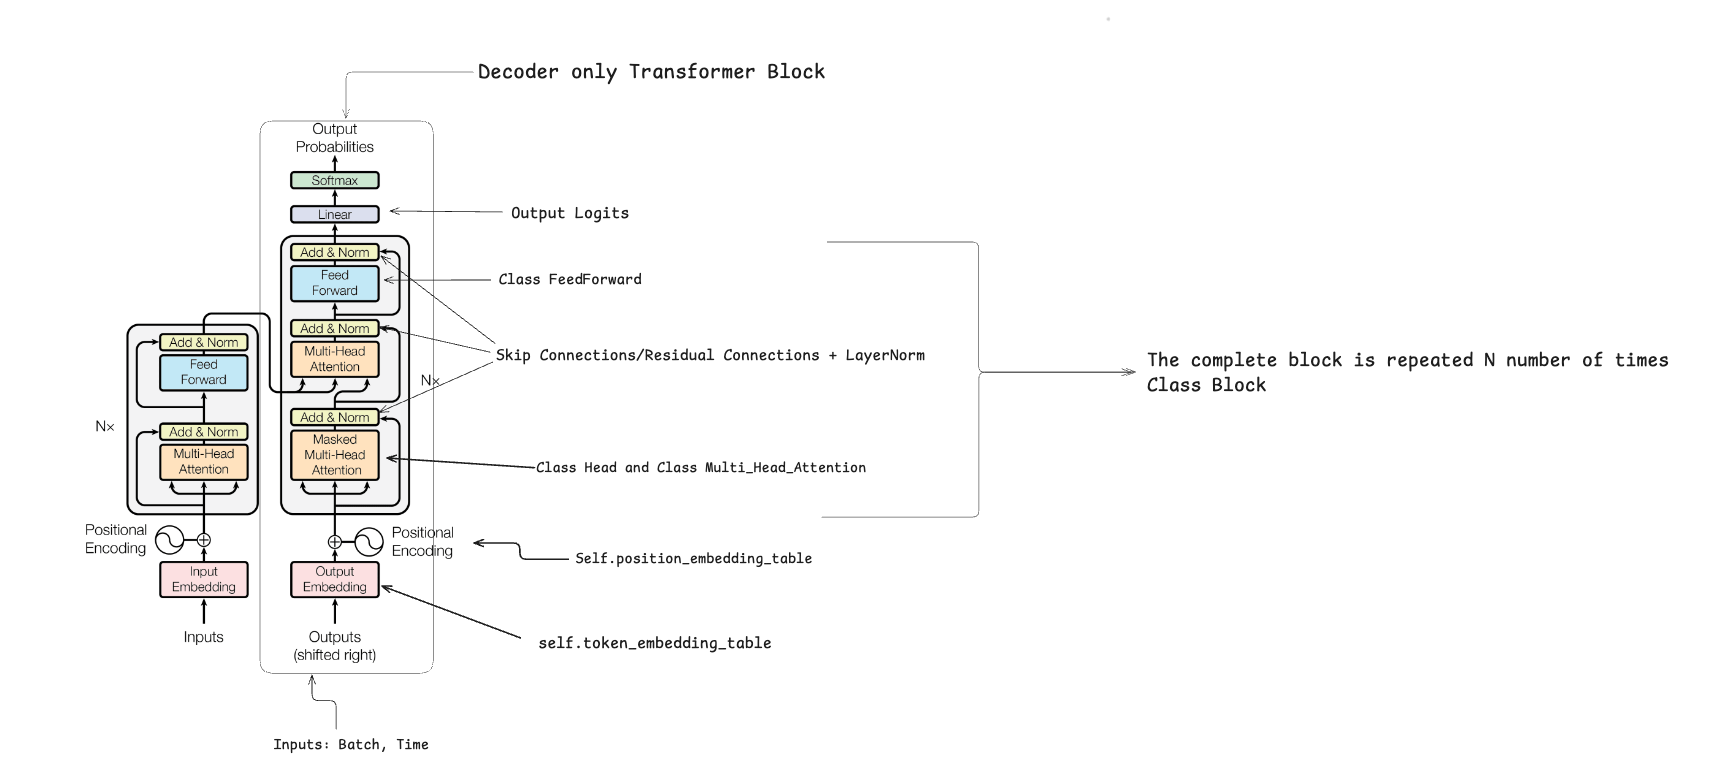

In [17]:
import torch.nn as nn
k = nn.Linear(10,2)
x = torch.randn((5,10,10))
q = k.forward(x)
q.shape


torch.Size([5, 10, 2])

In [ ]:
import torch.nn as nn

class Head(nn.Module):
    '''One head of self-attention'''

    def __init__(self, head_size) -> None:
        super().__init__()
        self.head_size = head_size
        # initialse each q,k,v vector as (n_embd,head_size) as we want each of these to interact with each token which itself is represented by a (65dimension vector) 1 T = 65, so anything that
        # needs to interact with 1 T must be, 65 by x
        self.key = nn.Linear(n_embd,head_size,bias=False) 
        self.query = nn.Linear(n_embd,head_size,bias=False)
        self.value = nn.Linear(n_embd,head_size,bias=False)
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size))) #as we can expect an input upto context length, we need to create a lookup sq. matrix of that size.

    def forward(self,x):
        B,T,C = x.shape # B,T,C
        k = self.key(x)  # B,T,head_size 
        q = self.query(x) # B,T,head_size
        v = self.value(x) # B,T,head_size

        # the scaled dot-product attention term factor helps prevent the dot products from growing too large in magnitude during attention calculations
        # Without this scaling, the dot products would grow with the size of the attention heads, potentially leading to very sharp softmax distributions and poor gradient flow.
        # The larger the head size, the smaller this scaling factor becomes, which helps maintain stable gradients during training.
        λ = self.head_size**-0.5
        
        # We will have T queries, the total no. of tokens
        # for each token T, we will have T keys, which is the last dimension
        # cause each tokens Query needs to look at keys of all other tokens
        wei = (q @ k.transpose(-2,-1)) * λ # B,T,head_size @ B,head_size,T => # B,T,T

        # We will fetch a square matrix of size T,T from tril to mask our q@k matrix wei
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf')) # type: ignore # B,T,T
        
        # We softmax along last dimension as for each query, we need a prop distribution matrix of size (T)
        # i.e each Tokens query must know what is the weight of all other tokens keys
        # This ensures that for each query position, the attention weights across all key positions sum to 1
        wei = F.softmax(wei,dim=-1) # B,T,T

        # Now we finally deliver the payload V, weighted by the softmax prob distribution
        out = wei @ v # B,T,T @ B,T,head_size => B,T,head_size

        # This out is added to our token embeddings X, to include in them the attention computation
        return out

        
class CausaulSelfattention:
    pass

class MultiHeadAttention(nn.Module):
    '''Multiple heads of self-attention'''

    def __init__(self,num_heads,head_size) -> None:
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd,n_embd)
    
    def forward(self,x):
        out = torch.cat([h(x) for h in self.heads],dim=-1) # Catting (B,T,head_size) across head_size  = (B,T,head_size*num_heads) will return to us the dim(-1) as n_embedding = 64
        out = self.proj(out) #we project because we want to fork-off to do some computation, then merge it into the residual connection
        return out
    
class FeedForward(nn.Module):
    '''Simple linear layer followed by a non-linearity'''
    # FF applies a mini brain only to that token, with no interaction with others
    # Think of attention as "talking to your friends", and FeedForward as "processing that info alone in your head."
    # expands, activates, compresses. Like thinking hard then summarizing.

    def __init__(self, n_embd) -> None:
        super().__init__()
        # expands, activates, compresses. Like thinking hard then summarizing.
        self.net = nn.Sequential(
            nn.Linear(n_embd,4*n_embd), # After the tokens have communicated via attention we want the tokens to think, and to do it we project the embedding into a 4X dimension vector , basically increase the computation width
            nn.ReLU(),  # Non-linearity to capture complex interactions
            nn.Linear(4*n_embd,n_embd) # And then collapse it back.
        )

    def forward(self,x):
        out = self.net(x)
        return out

class Block(nn.Module):
    '''Simple linear layer followed by a non-linearity'''
    
    def __init__(self,n_embd,n_head) -> None:
        super().__init__()
        head_size = n_embd//n_head
        self.sa = MultiHeadAttention(n_head,head_size) #i.e 4 heads of 8-dimensional heads
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd) #prenorm-formulation
        self.ln2 = nn.LayerNorm(n_embd) #layernorm is done per-feature, i.e mean and variance is calculated each token across 32dim vectors
    
    def forward(self,x):
        x = x + self.sa(self.ln1(x)) #intiating skip connections
        x = x + self.ffwd(self.ln2(x)) #intiating skip connections 
        return x


class BigramLanguageModel(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        # we embedd the tokens
        self.token_embedding_table = nn.Embedding(vocab_size,n_embd) #n_embd = C 
        self.position_embedding_table =  nn.Embedding(block_size ,n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd,4),
            Block(n_embd,4),
            Block(n_embd,4),
            nn.LayerNorm(n_embd)
        )
        self.lm_head = nn.Linear(n_embd,vocab_size) #the last linear layer to map back to vocab size

    def forward(self,idx,targets=None):
        B , T = idx.shape
        # we grab the corresponding embeddings
        token_embd = self.token_embedding_table(idx) # (B,T,C)
        pos_embd = self.position_embedding_table(torch.arange(T)) # (T,C) #we use smart indexing to get positional embeddings upto current context length
        x = token_embd + pos_embd #addition as we're just adding in the context of position (B,T,C) + (T,C) = (B,T,C)
        x = self.blocks(x)
        logits = self.lm_head(x) # (B,T,vocab_size)
        
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)

            loss = nn.functional.cross_entropy(logits,targets)
        
        return logits,loss
    
    def generate(self,idx,max_tokens):
        for _ in range(max_tokens):
            # when our generation grows longer than block_size, we would still want to feed in 8 characters at a time, as this ensures we never run out of scope in our embedding table which is (block_size ,n_embd)
            # so we clip the idx, to only contain the last 8 tokens or whatever blocks_size we chose
            idx_cond = idx[:, -block_size:] 
            logits,loss = self(idx_cond)
            logits = logits[:,-1,:] # only get the last logit
            probs = nn.functional.softmax(logits,dim=-1)
            idnext = torch.multinomial(probs,num_samples=1)
            idx = torch.cat((idx,idnext),dim=1)
        return idx

    # def __repr__(self):
    #     return f'BigramLanguageModel with {self.token_embedding_table}'


m = BigramLanguageModel()
out,loss = m(xb,yb)
print(out.shape)
print(f'{loss.item():.4f}')

torch.Size([1024, 65])
4.3906


In [ ]:
x = nn.Embedding(5,10)
x = nn.Lin

In [51]:
x.forward(torch.arange(5))

tensor([[-1.1737, -0.4608, -0.9193, -0.5393,  1.3293,  0.3002,  0.2826, -0.8950,
         -0.2187,  0.0471],
        [-0.3910,  0.0854, -1.4788, -0.0932,  0.0022,  1.5281, -0.7444, -0.6860,
         -0.6626, -0.1409],
        [-0.1579,  1.0010, -0.4058, -1.4761,  0.1973, -1.5185,  1.7401,  1.1585,
         -0.7644,  1.0494],
        [-2.0883,  0.4537,  1.3963,  0.7299,  0.8716, -0.2585,  1.3156,  0.7575,
         -0.0828,  0.3479],
        [ 0.2863, -1.2736, -1.6345, -0.5857, -0.0309,  1.6523, -0.0819,  0.3800,
          0.0162,  0.7662]], grad_fn=<EmbeddingBackward0>)

In [26]:
import torchlens as tl

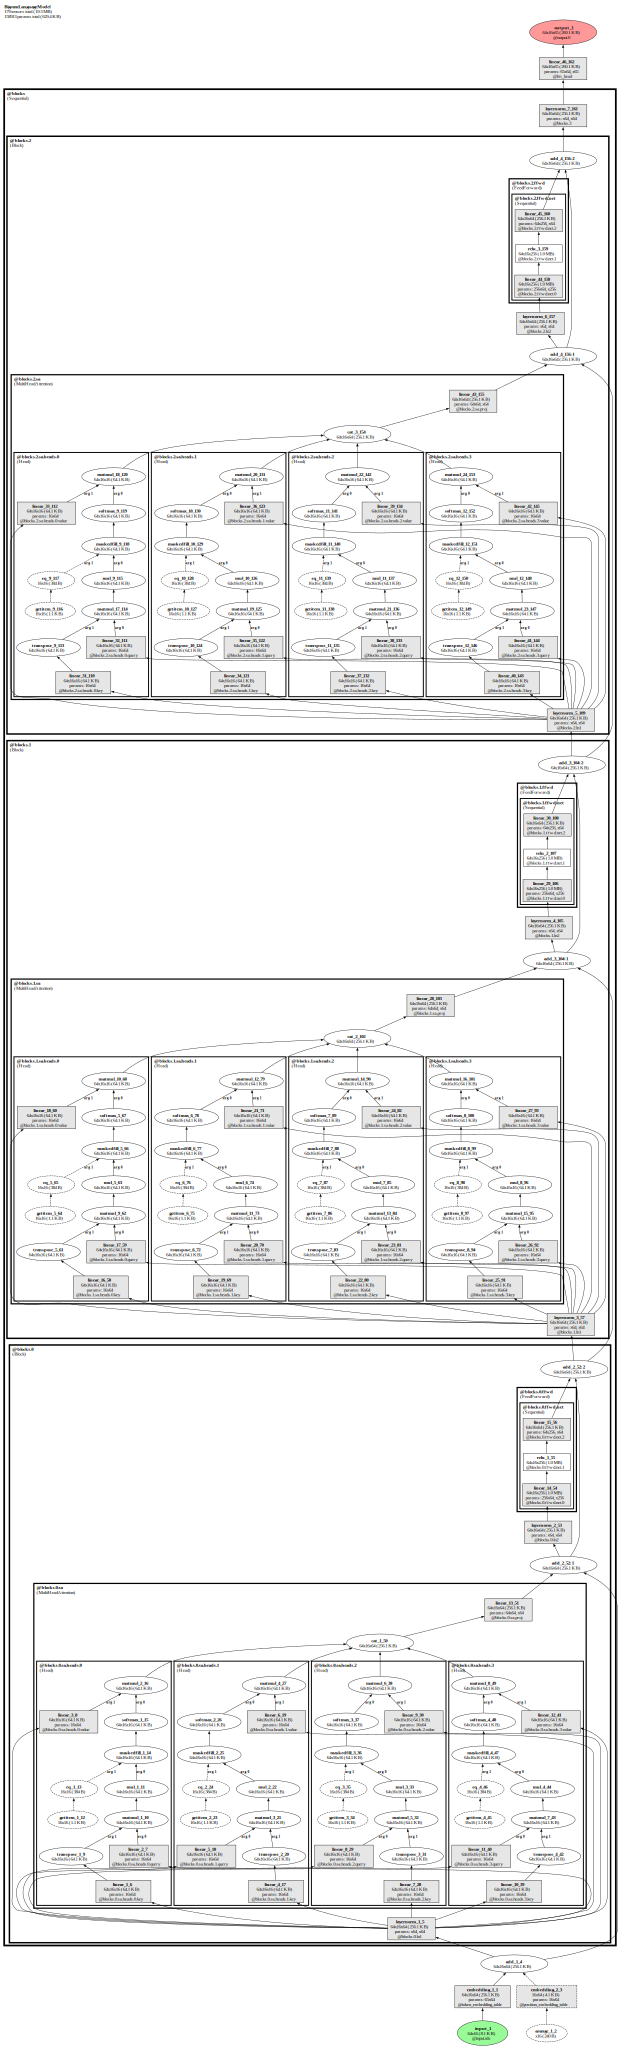

Log of BigramLanguageModel forward pass:
	Random seed: 3734659105
	Time elapsed: 4.65s (4.63s spent logging)
	Structure:
		- recurrent (at most 2 loops)
		- with branching
		- no conditional (if-then) branching
		- contains 12 buffer layers
		- 83 total modules
	Tensor info:
		- 179 total tensors (19.3 MB) computed in forward pass.
		- 179 tensors (19.3 MB) with saved activations.
	Parameters: 55 parameter operations (158913 params total; 629.4 KB)
	Module Hierarchy:
		token_embedding_table
		position_embedding_table
		blocks
		    blocks.0
		        blocks.0.ln1
		        blocks.0.sa
		            blocks.0.sa.heads.0
		                blocks.0.sa.heads.0.key, blocks.0.sa.heads.0.query, blocks.0.sa.heads.0.value
		            blocks.0.sa.heads.1
		                blocks.0.sa.heads.1.key, blocks.0.sa.heads.1.query, blocks.0.sa.heads.1.value
		            blocks.0.sa.heads.2
		                blocks.0.sa.heads.2.key, blocks.0.sa.heads.2.query, blocks.0.sa.heads.2.value
		            bloc

In [27]:
model_history = tl.log_forward_pass(m, xb, layers_to_save='all', vis_opt='unrolled')
print(model_history)

In [21]:
2.4065747261047363

2.4065747261047363

In [22]:
optimizer = torch.optim.AdamW(m.parameters(),lr = learning_rate)

In [23]:
for steps in range(1000):

    xb,yb = get_batch('train')

    logits,loss = m(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

KeyboardInterrupt: 

In [ ]:
sum(p.numel() for p in m.parameters())

158017

In [ ]:
ix = torch.zeros((1,1),dtype=torch.long)
print((decode(m.generate(ix,1000)[0].tolist())))


To me as I am
I buthe:'sty, to 'tis to upon molethis virtisfour; i' which not why trusking they;
Fillow thou have air, we brothink,
Golk, die plaian,
Appearlich my stand; and is a apition,
I come hibla feer,
So me my formen reigne.

LADY CARLANUS:
Lear my have graced close condister to laughter him the Dewell againstry, as hi, majunke tay comfored of how of is score.
I'll as to for of to know; ghomiers; io-roub't I cannot apport:
Mill deafly ploiburgs
Thankyst and lreother stapion
Eldenchy sir'd
eathine?

BUCKINGHES:
The Vear an hem, in the done.'
Seply Mark?

BRAMARD IIENTEN:
Se'erd Rome, to shame a at haredy.

SATHASTO:
Whul! What know, and a king.

CORIOLEY:
To reward's the than was flaulty.

DUKE OF GAUMERLE:
Horem thy warry deep hithere grace;
A blay  greation king millo. Which a damedeh.

NOMNSTHUSBROKE:
Shy goode his the full action.
You muster, I ear.

LAUCIO:
Where Rome in tween! chardering.

BRUTUS:
The rughtles they very were, I prower, we't.

KING RICHARD III:
Where that n

# Below is just some starter code to help us understand some concepts and is not relevant to the model above.

In [ ]:
import numpy as np
ls = np.random.randint(0,10,(5,5))
ls

array([[9, 8, 6, 4, 6],
       [1, 9, 5, 9, 8],
       [3, 8, 3, 4, 6],
       [1, 7, 0, 5, 0],
       [9, 4, 3, 2, 0]])

In [ ]:
ls[:,-3:]

array([[6, 4, 6],
       [5, 9, 8],
       [3, 4, 6],
       [0, 5, 0],
       [3, 2, 0]])

In [ ]:
ix = torch.zeros((1,1),dtype=torch.long)
for i in range(100):
    idx_cond = ix[:, -block_size:]
    logits = m.forward(idx_cond)[0]
    logits = logits[:,-1,:]
    probs = nn.functional.softmax(logits,-1)
    idnext = torch.multinomial(probs,num_samples=1)
    ix = torch.cat((ix,idnext),dim=1)
print(ix.shape)
print(decode(ix[-1].tolist()))

torch.Size([1, 101])

Mursely-mand
to lood to ghtons thenoularlouls chen't, alay nobly nestivent blobe not not mike me too


In [ ]:
decode([ 0, 31])

'\nS'

In [ ]:
idx = torch.randint(0,100,(2,5))
idnext = torch.tensor([[2,1],
                       [2,2]])
idx = torch.cat((idx,idnext),dim=1)
idx

tensor([[85, 19,  0, 88, 68,  2,  1],
        [90, 71, 82, 47, 66,  2,  2]])

In [ ]:
tokens = torch.randint(0,65,(4,8))
embedding_matrix = torch.randn(65,65,requires_grad=True)
final_matrix = nn.functional.embedding(tokens, embedding_matrix)
final_matrix.shape

torch.Size([4, 8, 65])